# Boosted tree machine learning model with XGBoost classifier

Create a ML model for the batch-preprocessed review information to predict target = 'review stars' of an individual review.

Steps:
- 1 - load batch preprocessed review & business information
- 2 - train/test split
- 3 - fit 'review stars' with an XGBoost Classifier
- 4 - determine what the top features are for the XGBoost model & see how the model changes by removing them
- 5 - save predictions on a test set to do informative, actionable feature extraction post modeling

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

#Import saved data that has been batch processed from 3_batch_process.py ~2m reviews of the 6.9m

#Merge the batch processed files and load as one dataframe business_reviews
joined_csv = os.path.join('../csv_processed/batches', '*.csv')
joined_list = glob.glob(joined_csv)
business_reviews = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)
print(f'total reviews to train/test split on: {len(business_reviews)}')

#Create a random test set for detailed analysis later on since we don't have a 'true' test set
business_reviews_test = business_reviews.sample(n=100000, random_state=0)
business_reviews = business_reviews.drop(business_reviews_test.index)

#Setup training:
#Remove pure text
business_reviews.drop(['text'], axis=1, inplace=True)

#Attempt to get a more generic bad = 0, average = 1, great = 2 score
    #improves model performance and still allows us to extract key words
    #when a review has strong positive/negative sentiment
stars_map = {1:0, 2:0, 3:1, 4:2, 5:2}
business_reviews['review stars'] = business_reviews.replace({'review stars': stars_map})['review stars']

#Select features and target
y = business_reviews.pop('review stars')
X = business_reviews

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=101)

total reviews to train/test split on: 2100000


In [3]:
#Define and train model
model = XGBClassifier(n_estimators=500, 
                      early_stopping_rounds=5, 
                      learning_rate=0.01,
                      tree_method='gpu_hist', gpu_id=0)

#Fit the model
model.fit(X_train, y_train,
         eval_set=[(X_valid, y_valid)],
         verbose=100)

predictions = model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))
print("\nFeature importances: ")
feat = list(zip(business_reviews.columns, model.feature_importances_))
for i in range(0, len(feat)):
    print(*feat[i])

#Print the classification report of the fit    
print(confusion_matrix(y_valid, predictions))
print(classification_report(y_valid, predictions))

[0]	validation_0-mlogloss:1.08685
[100]	validation_0-mlogloss:0.49410
[200]	validation_0-mlogloss:0.32944
[300]	validation_0-mlogloss:0.27584
[400]	validation_0-mlogloss:0.25720
[499]	validation_0-mlogloss:0.25014
Mean Absolute Error: 0.1069475

Feature importances: 
useful 0.0041557387
funny 0.003376723
cool 0.004637977
business stars 0.006322853
review_count 0.0019162861
year 0.0031314439
month 0.00042630287
hour 0.00058133213
length 0.0014367744
sentence count 0.0012927856
pt sentiment 0.0046434063
pt sentiment score 0.0030361738
ft positive 0.390591
ft neutral 0.14619704
ft negative 0.40970072
food 0.0032962493
shop 0.003134033
health 0.0004052188
housing 0.00056787033
education 0.0001167003
entertainment 0.0051371367
services 0.0041261245
cluster 0.001770215
[[ 83400   5742   2059]
 [  9602  18144  12956]
 [  2208   5945 259944]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     91201
           1       0.61      0.45      0.51 

Our model performs the best on positive (4-5 stars) and negative (1-2 star) reviews. There is more support for positive/negative, and in general, a neutral/average sentiment is hard to distinguish versus strongly positive/negative sentiments & words. 

Text(0.5, 0, 'feature importance')

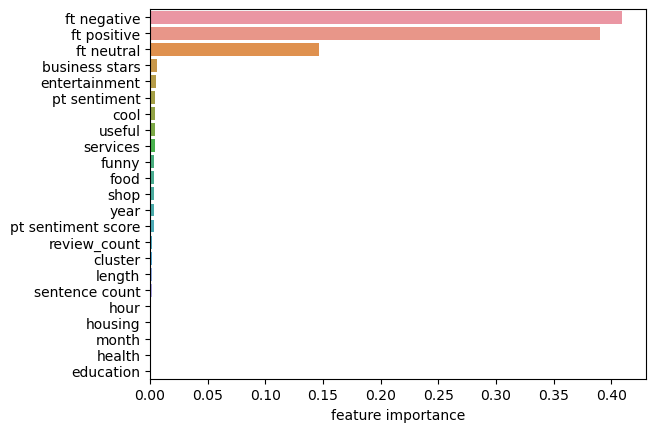

In [4]:
#Lets take a look at the feature importances in our XGBoost model
def sort_features(tupl):
    return sorted(tupl, key = lambda x: x[1])[::-1]

feat_sorted = np.transpose(sort_features(feat))
labels = feat_sorted[0]
values = [float(i) for i in feat_sorted[1]]

fig, ax = plt.subplots()
sns.barplot(x=values, y=labels)
ax.set_xlabel('feature importance')

Our plot clearly shows that pretraining/fine tuning a bert-base-uncased large language model is the best way to build a ML model to predict if a review will be positive/neutral/negative. Surprisingly, the pretrained roberta sentiment & score are further down the list than some of the generic business categories (entertainment, services) and the average review score of a business (business stars). 

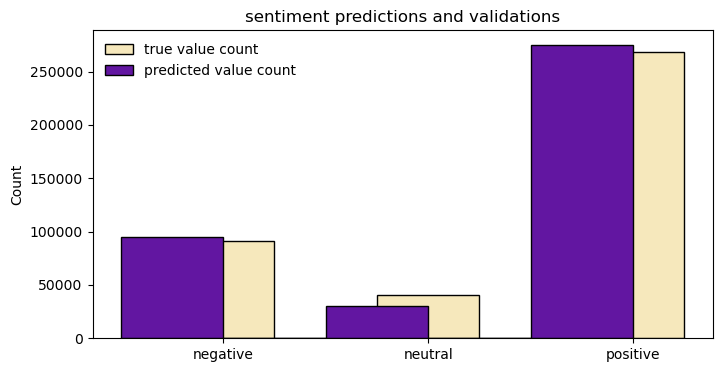

In [5]:
#Combine the validation predictions and true values
y_valid_preds = pd.DataFrame([np.array(y_valid), np.array(predictions)]).transpose()
y_valid_preds.rename(columns={0:'true value', 1:'predicted'}, inplace=True)

fig, ax = plt.subplots(figsize=(8,4))

g = sns.histplot(y_valid_preds['true value'], ax=ax, color='#e3b622', label=r'true value count',
                 alpha=0.3, binwidth=0.5, binrange=(0,2.5))
sns.histplot(y_valid_preds['predicted'], ax=ax, color='#6216a1', label=r'predicted value count',
             alpha=1, binwidth=0.5, binrange=(-0.25,2.25))

g.set_title('sentiment predictions and validations')
g.set_xlabel('')
g.set_xticks([0.25, 1.25, 2.25], ['negative', 'neutral', 'positive'])
plt.legend(loc='best', framealpha=0)

Again we can see the categories are skewed by total count, but overall the model seems to predict negative & positive review stances quite well.

### Lets take a closer look at the features in our model and see if fine tuning was really worth it.

In [6]:
X.dtypes

useful                  int64
funny                   int64
cool                    int64
business stars        float64
review_count            int64
year                    int64
month                   int64
hour                    int64
length                  int64
sentence count          int64
pt sentiment          float64
pt sentiment score    float64
ft positive           float64
ft neutral            float64
ft negative           float64
food                    int64
shop                    int64
health                  int64
housing                 int64
education               int64
entertainment           int64
services                int64
cluster                 int64
dtype: object

In [7]:
#Mutual information: which features are strongly linked?
from sklearn.feature_selection import mutual_info_regression

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

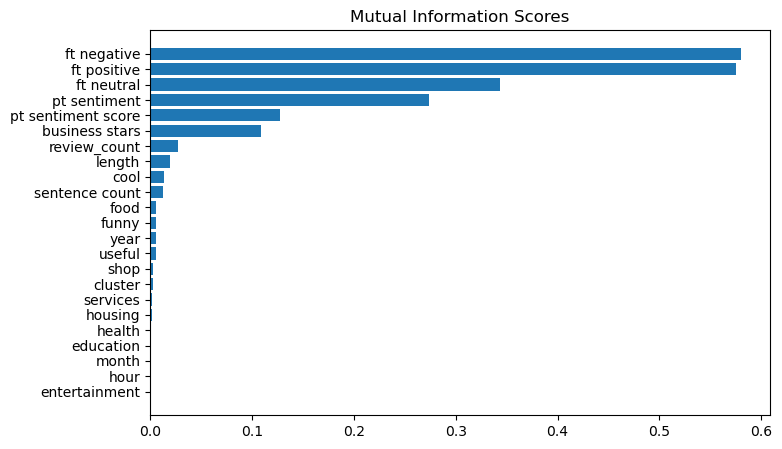

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Mutual information suggests something similar to what we saw with our feature importances in the XGBoost model. However, if we ignore the fine tuned (ft) negative/positive/neutral values from our bert-base-uncased model, then perhaps the pretrained sentiment would become a more important feature.

Lets test this.

[0]	validation_0-mlogloss:1.08897
[100]	validation_0-mlogloss:0.60353
[200]	validation_0-mlogloss:0.47221
[300]	validation_0-mlogloss:0.42979
[400]	validation_0-mlogloss:0.41403
[499]	validation_0-mlogloss:0.40721
Mean Absolute Error: 0.2071525
[[ 83400   5742   2059]
 [  9602  18144  12956]
 [  2208   5945 259944]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     91201
           1       0.61      0.45      0.51     40702
           2       0.95      0.97      0.96    268097

    accuracy                           0.90    400000
   macro avg       0.81      0.78      0.79    400000
weighted avg       0.90      0.90      0.90    400000



Text(0.5, 0, 'feature importance')

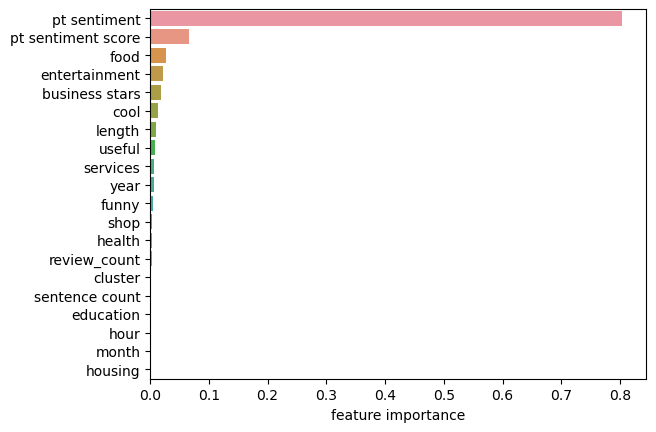

In [9]:
#Remove the fine tuned features and refit the XGBoost model

#Drop fine tuned columns
drop_features = ['ft negative', 'ft positive', 'ft neutral']
y_restricted = y
X_restricted = business_reviews.drop(columns=drop_features)

# Separate data into training and validation sets
X_train_restricted, X_valid_restricted, y_train_restricted, y_valid_restricted = train_test_split(X_restricted, y_restricted, 
                                                                                                  test_size=0.2, 
                                                                                                  random_state=101)

#Train model without the fine tuned parameters
model_restricted = XGBClassifier(n_estimators=500, 
                                 early_stopping_rounds=5, 
                                 learning_rate=0.01,
                                 tree_method='gpu_hist', gpu_id=0)

model_restricted.fit(X_train_restricted, y_train_restricted,
                     eval_set=[(X_valid_restricted, y_valid_restricted)],
                     verbose=100)

predictions_restricted = model_restricted.predict(X_valid_restricted)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions_restricted, y_valid_restricted)))  

feat_restricted = list(zip(X_restricted.columns, model_restricted.feature_importances_))

print(confusion_matrix(y_valid, predictions))
print(classification_report(y_valid, predictions))

feat_sorted_restricted = np.transpose(sort_features(feat_restricted))
labels_restricted = feat_sorted_restricted[0]
values_restricted = [float(i) for i in feat_sorted_restricted[1]]

fig, ax = plt.subplots()
sns.barplot(x=values_restricted, y=labels_restricted)
ax.set_xlabel('feature importance')

Removing the fine tuned (ft) features makes the pretrained (pt) sentiment score jump up significantly. However, our overall model error is significantly worse.

### 'Test' data set evaluation

In [18]:
#Lets save predictions of our 'test' set (100k dropped rows in at the top of this file)
    #for further analysis in 5_postmodel_analysis.ipynb

#Predict using the first XGBoost model
business_reviews_test['review stars'] = business_reviews_test.replace({'review stars': stars_map})['review stars']
y_test = business_reviews_test.replace({'review stars': stars_map})['review stars']
test_preds = model.predict(business_reviews_test.drop(['text', 'review stars'], axis=1))

business_reviews_test['prediction'] = test_preds
business_reviews_test.head(5)
# #Save the output
business_reviews_test.to_csv(r'../csv_processed/3_test_predictions.csv')